In [164]:
import os
import tarfile
import urllib

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import model_selection, impute, preprocessing, \
    base, pipeline, compose, linear_model, metrics, tree, ensemble
%matplotlib inline

## Get data

In [49]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [50]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [51]:
fetch_housing_data()

In [52]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [53]:
housing = load_housing_data()

In [54]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [55]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [56]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [57]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


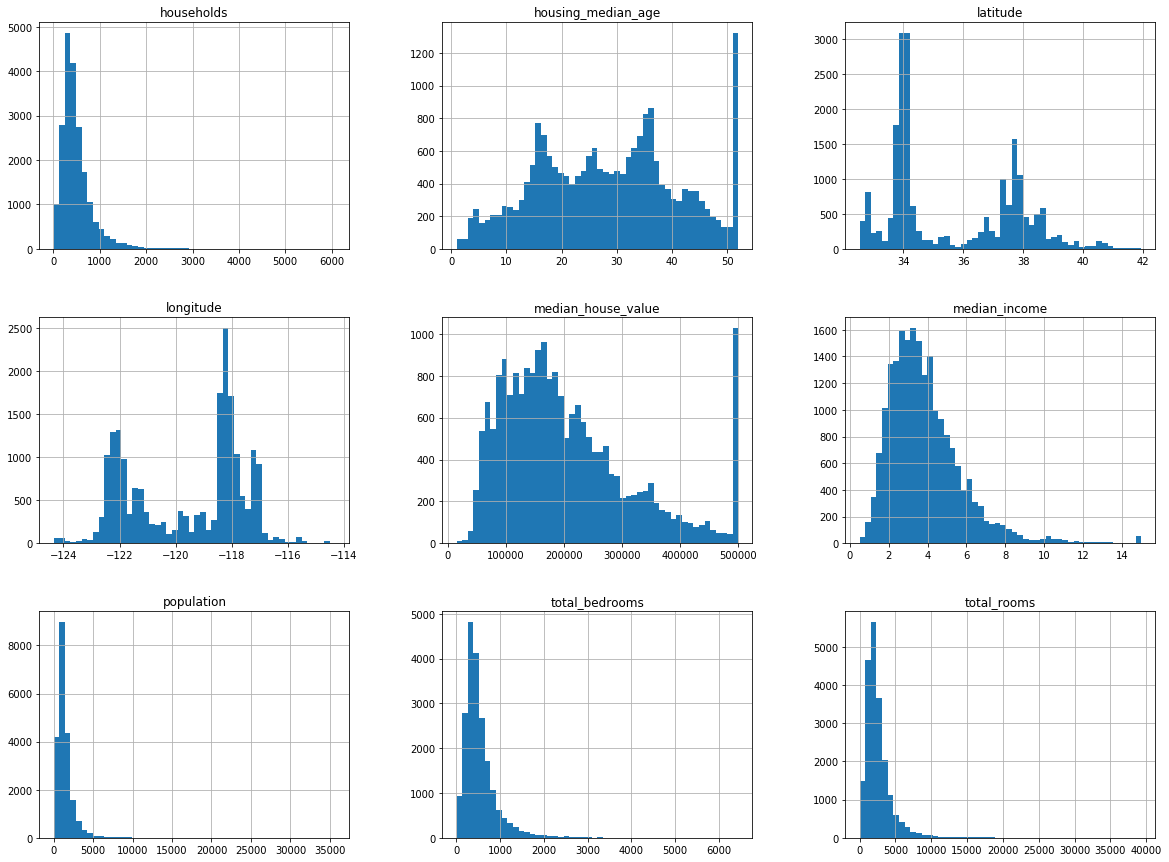

In [58]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

## Construct test set

In [59]:
# Create a test set NOW to prevent
# your brain, as well as any model, 
# from overfitting!!! (ie data snooping)

# Here are some various ways to implement
# a train/test splitting function

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [60]:
train_set, test_set = split_train_test(housing, 0.2)

In [61]:
# Implementation of a test-splitting function
# that allows the dataset to be updated yet
# consistently pick the same instances for
# the test set:

from zlib import crc32

def test_set_check(identifier, test_ratio):
    thing = crc32( np.int64(identifier) & 0xffffffff)
    other_thing = test_ratio * 2 ** 32
    is_test = thing < other_thing
    return is_test

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [62]:
housing_w_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_w_id, 0.2, "index")

In [63]:
# Using sklearn
train_set, test_set = model_selection.train_test_split(housing,
                                                       test_size=0.2,
                                                       random_state=42)

In [64]:
# Suppose we need to do stratified sampling to
# prevent errors from sampling bias in the test set:

bins = [0, 1.5, 3.0, 4.5, 6, np.inf]
labels = range(1, len(bins))  # 1-based labels
housing["income_cat"] = pd.cut(housing["median_income"], bins=bins, labels=labels)

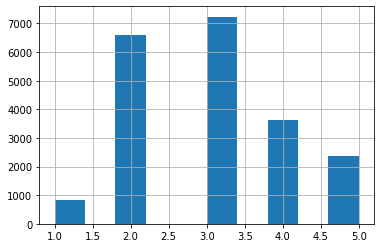

In [65]:
housing["income_cat"].hist()

In [66]:
# Now use sklearn to do a stratified split
kwargs = {
    "n_splits": 1,
    "test_size": 0.2,
    "random_state": 42
}
split = model_selection.StratifiedShuffleSplit(**kwargs)

In [67]:
gen = split.split(housing, housing["income_cat"])
for train_ix, test_ix in gen:
    strat_train_set = housing.loc[train_ix]
    strat_test_set = housing.loc[test_ix]

In [68]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [69]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualize data

In [70]:
# Training set is small enough to be used for EDA.
# Can always just take a smaller sample if that's
# not the case.
housing = train_set.copy()

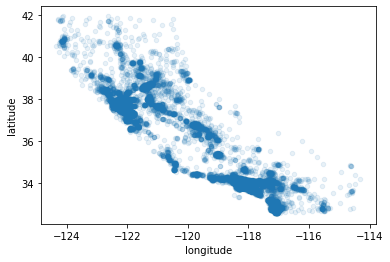

In [71]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

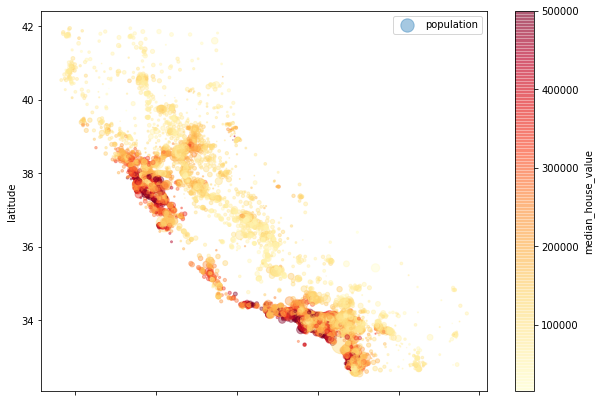

In [72]:
kwargs = {
    "kind": "scatter",
    "x": "longitude",
    "y": "latitude",
    "alpha": 0.4,
    "s": housing["population"] / 100,
    "label": "population",
    "figsize": (10, 7),
    "c": "median_house_value",
    "cmap": plt.get_cmap("YlOrRd"),
    "colorbar": True
}
housing.plot(**kwargs)
plt.legend();

In [73]:
# Pearson's r -- correlation btwn each pair of attributes
corr_matrix = housing.corr()

In [74]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

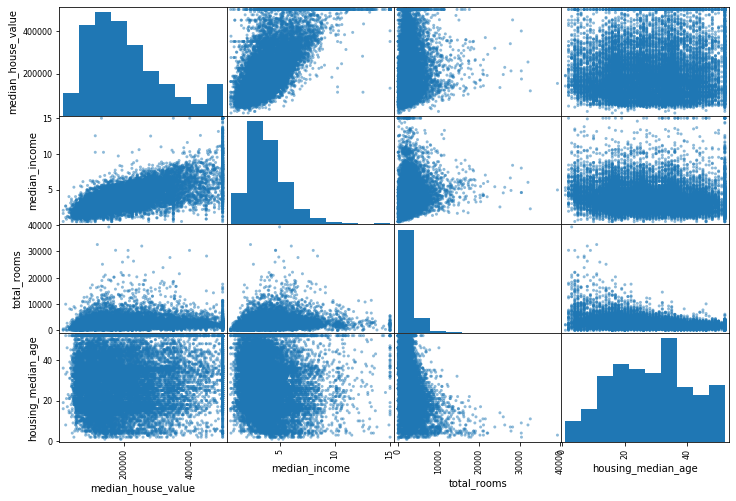

In [75]:
# Another way to check the correlation between attributes
attrs = ["median_house_value", "median_income", "total_rooms", 
         "housing_median_age"]
pd.plotting.scatter_matrix(housing[attrs], figsize=(12, 8));

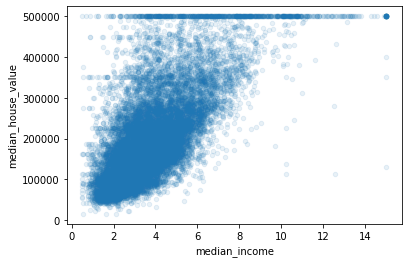

In [76]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

## Engineer some new features

In [77]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [78]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

## Prepare data for model

In [79]:
# Copy fresh
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

In [ ]:
# Some options to deal with missing values
housing.dropna(subset=["total_bedrooms"])  # Drop rows
housing.drop("total_bedrooms", axis=1)     # Drop column
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)   # Fill with value (median)

In [80]:
# Using sklearn
# SimpleImputer doesn't take nonnumeric features
imputer = impute.SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [81]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [82]:
housing.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [83]:
# Use "trained" imputer to "transform" the data
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)

In [84]:
# Categorical attributes
housing_cat = housing[["ocean_proximity"]]

In [85]:
# Trafo to ordinal
# Output is an np.array
ordinal_encoder = preprocessing.OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [88]:
# Categorical encoding / dummies
# Output is a scipy sparse matrix
cat_encoder = preprocessing.OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [92]:
# Custom transformer
# Just need to implement .fit(), 
# .transform(), and fit_transform().

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        # Nothing to do -- this is a passthrough operation
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        args = [X, rooms_per_household, population_per_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [93]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [99]:
# Pipeline for numerical features only

num_pipeline = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", preprocessing.StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [108]:
# Pipeline to handle both numeric and categorical features

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Can specify "drop" instead of a transformer to just drop a column
full_pipeline = compose.ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", preprocessing.OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model

In [109]:
# Start with a linear regression
lin_reg = linear_model.LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
# Try it out on a few instances of the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [117]:
# Not great.
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = metrics.mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"RMSE: {round(lin_rmse, 1)}")

RMSE: 68628.2


In [119]:
# Try a Decision Tree instead
tree_reg = tree.DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [120]:
# Overfit!
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = metrics.mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"RMSE: {round(tree_rmse, 1)}")

RMSE: 0.0


In [122]:
# Ofc a better way to evaluate this
# model is to cross-validate.

# cross_val_score requires a utility function, not a cost function
scoring = "neg_mean_squared_error"

scores = model_selection.cross_val_score(tree_reg, housing_prepared,
                                         housing_labels, scoring=scoring,
                                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [123]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [124]:
display_scores(tree_rmse_scores)

Scores: [70571.67126422 67950.09216318 70369.31544748 68714.95265154
 71412.05869628 74501.47325837 70579.82657418 71847.83851483
 76984.91769455 70437.30870398]
Mean: 71336.94549686059
Standard Deviation: 2518.5438161432717


In [127]:
scoring = "neg_mean_squared_error"
lin_scores = model_selection.cross_val_score(lin_reg, housing_prepared,
                                             housing_labels, scoring=scoring,
                                             cv=10)
lin_rmse = np.sqrt(-lin_scores)

In [128]:
display_scores(lin_rmse)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983493


In [132]:
# Random Forest
forest_reg = ensemble.RandomForestRegressor()
scoring = "neg_mean_squared_error"
forest_scores = model_selection.cross_val_score(forest_reg, housing_prepared,
                                               housing_labels, scoring=scoring,
                                               cv=10)
forest_rmse = np.sqrt(-forest_scores)
display_scores(forest_rmse)

Scores: [49509.46721035 47501.53667173 50107.77656337 52542.57522846
 49872.52506937 53704.81032797 48681.81264712 48135.05151278
 53290.46749336 49982.83602445]
Mean: 50332.88587489627
Standard Deviation: 2040.4927603838753


## Fine Tune the model

In [136]:
# Grid search
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]
forest_reg = ensemble.RandomForestRegressor()
scoring = "neg_mean_squared_error"
grid_search = model_selection.GridSearchCV(forest_reg, param_grid, cv=5,
                                          scoring=scoring, return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [137]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [140]:
# refit parameter (default to True) causes
# the best estimator to be subsequently
# retrained on the whole training data set.

grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [146]:
# Evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(np.sqrt(-mean_score)), params)

64787.0 {'max_features': 2, 'n_estimators': 3}
56227.0 {'max_features': 2, 'n_estimators': 10}
52838.0 {'max_features': 2, 'n_estimators': 30}
59889.0 {'max_features': 4, 'n_estimators': 3}
53170.0 {'max_features': 4, 'n_estimators': 10}
50630.0 {'max_features': 4, 'n_estimators': 30}
59496.0 {'max_features': 6, 'n_estimators': 3}
52142.0 {'max_features': 6, 'n_estimators': 10}
50058.0 {'max_features': 6, 'n_estimators': 30}
59370.0 {'max_features': 8, 'n_estimators': 3}
52058.0 {'max_features': 8, 'n_estimators': 10}
50163.0 {'max_features': 8, 'n_estimators': 30}
62274.0 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54314.0 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60298.0 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52511.0 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59090.0 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51740.0 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [160]:
# Inspect the most important features
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.40549375e-02, 7.53246350e-02, 4.15547016e-02, 1.81566911e-02,
       1.66090437e-02, 1.72135388e-02, 1.60524266e-02, 2.72264345e-01,
       6.23436874e-02, 1.12105801e-01, 1.12768958e-01, 1.19310395e-02,
       1.45162486e-01, 7.27015393e-05, 5.25526750e-03, 9.12973980e-03])

In [161]:
extra_attribs = ["rooms_per_hh", "pop_per_hh", "bedrooms_per_hh"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2722643445283294, 'median_income'),
 (0.14516248638575197, 'INLAND'),
 (0.11276895778877617, 'bedrooms_per_hh'),
 (0.11210580121351837, 'pop_per_hh'),
 (0.08405493752933454, 'longitude'),
 (0.0753246350257511, 'latitude'),
 (0.062343687420567805, 'rooms_per_hh'),
 (0.04155470155311532, 'housing_median_age'),
 (0.01815669112739703, 'total_rooms'),
 (0.01721353880800102, 'population'),
 (0.016609043711750822, 'total_bedrooms'),
 (0.01605242659451762, 'households'),
 (0.011931039478446544, '<1H OCEAN'),
 (0.009129739797967029, 'NEAR OCEAN'),
 (0.005255267497519637, 'NEAR BAY'),
 (7.27015392556215e-05, 'ISLAND')]

In [163]:
# Try out the fianl model on the test set.

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# When running the pipeline on the test data,
# need to call .transform()...NOT .fit_transform()!
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = metrics.mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"RMSE of final model: {round(final_rmse)}")

RMSE of final model: 47712.0


In [167]:
# A measure of how narrow the 95% confidence interval is

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
interval_sq = stats.t.interval(alpha=confidence, df=len(squared_errors) - 1,
                               loc=squared_errors.mean(),
                               scale=stats.sem(squared_errors))
confidence_interval = np.sqrt(interval_sq)
lower = round(confidence_interval[0])
upper = round(confidence_interval[1])
print(f"{confidence*100}% confidence interval of test error: [{lower}, {upper}]")

95.0% confidence interval of test error: [45710.0, 49633.0]
